In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as patches
from matplotlib import cm

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v8_IRLS'

# Panel a

In [3]:
res_corsi = loadmat(f'../../../all_corsi_log_{version}.mat')['all_corsi'][0]

res_2back = loadmat(f'../../../all_2back_log_{version}.mat')['all_2back'][0]

res_rtime = loadmat(f'../../../all_rtime_log_{version}.mat')['all_r_time']

res_switch = loadmat(f'../../../all_switch_log_{version}.mat')['all_switch']

res_sRT = res_rtime[0]
res_cRT = res_rtime[1]
res_global = res_switch[0]
res_local = res_switch[1]


Reaction time (simple) = 0.023
Reaction time (choice) = 0.348
Task switch (global cost) = 0.070
Task switch (local cost) = 0.017
Corsi = 0.133
2-back = 0.012


,p-value,N,beta,test,f-value,R2
0,4.521563e-02,179,0.564302,Reaction time (simple),4.067945,0.022935
1,0.000000e+00,180,3.490883,Reaction time (choice),95.183119,0.348436
2,3.992414e-03,117,0.001175,Task switch (global cost),8.631747,0.069912
3,1.679555e-01,117,-0.000448,Task switch (local cost),1.925308,0.016656
4,7.277214e-07,175,-0.025004,Corsi,26.447025,0.133453
5,2.564346e-01,128,-0.014917,2-back,1.299678,0.011696


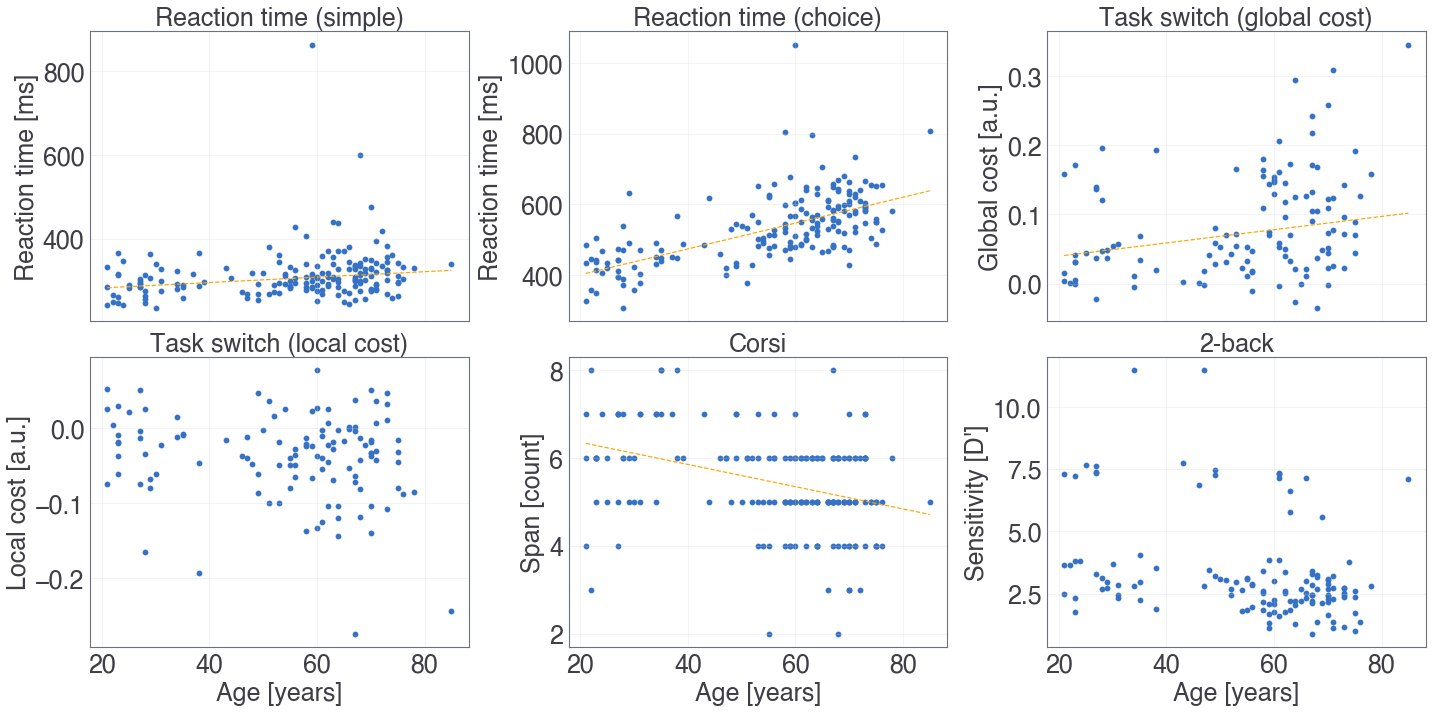

In [20]:
TITLES = ['Reaction time (simple)', 'Reaction time (choice)', 'Task switch (global cost)', 'Task switch (local cost)', 'Corsi', "2-back"] 
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True)

df_fig4pana = pd.DataFrame(columns={'test', 'N', 'R2', 'p-value', 'f-value', 'beta'})

for IDX in range(6):

    age = VALUES[IDX][0].flat[0][3]
    gender = VALUES[IDX][0].flat[0][4]
    data_it = VALUES[IDX][0].flat[0][2].flat[0]  # residual 
    gender_k = data_it[6].flat[0][3]

    k = data_it[5].flat[0][3]
    r2 = data_it[5].flat[0][0]
    fval = data_it[5].flat[0][1]
    p = data_it[5].flat[0][2]
    
    gender_corrected_res = data_it[4]
    print(f"{TITLES[IDX]} = {r2[0][0]:.3f}")
    _min = np.argmin(age)
    _max = np.argmax(age)
    
    ax[IDX // 3][IDX % 3].scatter(age, gender_corrected_res + gender * gender_k[0] + gender_k[1])
    if p[0][0] < 0.05:
        ax[IDX // 3][IDX % 3].plot([age[_min], age[_max]], np.array([age[_min], age[_max]]) * k[0] + k[1] + np.array([gender[_min], gender[_max]]) * gender_k[0] + gender_k[1], '--', color='orange')
    ax[IDX // 3][IDX % 3].set_title(TITLES[IDX])
    
    _ylim = ax[IDX // 3][IDX % 3].get_ylim()[1]
    df_fig4pana = df_fig4pana.append({'test': TITLES[IDX], 'N': len(age), 
                                      'R2': r2[0][0], 'p-value': p[0][0], 
                                      'f-value': fval[0][0], 'beta':k[0][0]}, ignore_index=True)
    ax[IDX // 3][IDX % 3].grid(True, alpha=0.5, linewidth=0.5)
#     ax[IDX // 3][IDX % 3].text(20,  _ylim * 0.7, f"R2 = {r2[0][0]:.2f} \np-val = {p[0][0]:.2e}", fontsize=20)

ax[0][0].set_ylabel('Reaction time [ms]')
ax[0][1].set_ylabel('Reaction time [ms]')
ax[0][2].set_ylabel('Global cost [a.u.]')
ax[1][0].set_ylabel('Local cost [a.u.]')
ax[1][1].set_ylabel('Span [count]')
ax[1][2].set_ylabel("Sensitivity [D']")

ax[1][0].set_xlabel("Age [years]")
ax[1][1].set_xlabel("Age [years]")
ax[1][2].set_xlabel("Age [years]")
plt.tight_layout()
plt.savefig('figure_5_panel_a.pdf')
df_fig4pana.to_csv(f'figure_5_panel_a.csv', index=False)
df_fig4pana

# Panel b

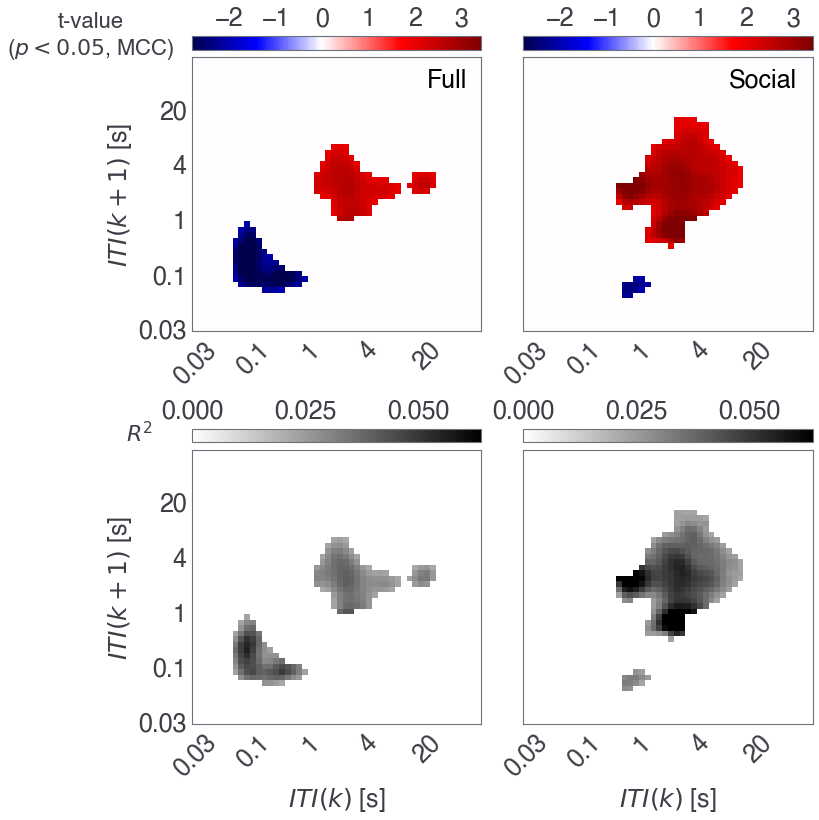

In [25]:
TITLES = ['cRT', 'switchGlobal'] 
VALUES = [res_cRT, res_global]
fig, ax = plt.subplots(2, 2, figsize=(11.5, 11.5), sharey=True)
jid_title = ['Full', 'Social', 'Transition']
x_bias = [40, 35, 27]
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0 # 0 == cRT // 1 == switchGlobal

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(2):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]  # residual
    mask = data_it[7].reshape(50, 50).T
    p_vals = data_it[8].reshape(50, 50).T
    f_vals = data_it[9].reshape(50, 50).T
    r_vals = data_it[10].reshape(50, 50).T
    r2_vals = data_it[11].reshape(50, 50).T
    k = data_it[12][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_vals, 99))
    vmin_r = min(vmin_r, np.percentile(r2_vals, 1))

th_R2 = 0.1

for i, _title in enumerate(['Full', 'Social']):

    # val for age
    val = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    mdl = val[2]
    r2_full = np.zeros(2500)
    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
    mask_age_r2 = r2_full.reshape(50, 50).T > th_R2
    
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[7].reshape(50, 50).T
    p_vals = data_it[8].reshape(50, 50).T
    f_vals = data_it[9].reshape(50, 50).T
    r_vals = data_it[10].reshape(50, 50).T
    r2_vals = data_it[11].reshape(50, 50).T
    k = data_it[12][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    im = ax[0][i].imshow(mask_age_r2 * np.sign(mask) * np.sqrt(f_vals) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=vmin_f, vmax=vmax_f))
    ax[0][i].text(x_bias[i], 44, f"{jid_title[i]}", fontsize=25, color='black')
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
#     r2_vals[r2_vals < 1e-5] = 0
    
    im = ax[1][i].imshow(mask_age_r2 * np.sign(mask) * r2_vals, aspect='auto', cmap='binary',
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none', norm=TwoSlopeNorm(0, vmin=-0.01, vmax=vmax_r))
    
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(f'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-18, 50, 't-value\n' + r'($p<0.05$, MCC)', size=22, ha='center')   
ax[1][0].text(-12, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig(f'figure_5_panel_b_{TITLES[IDX]}.pdf', transparent=True)

# Panle c

# 

<ipython-input-29-ecf5a2ae15c8>:21: UserWarning: No contour levels were found within the data range.
  im = ax[i].contour(Z * np.sign(mask), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)


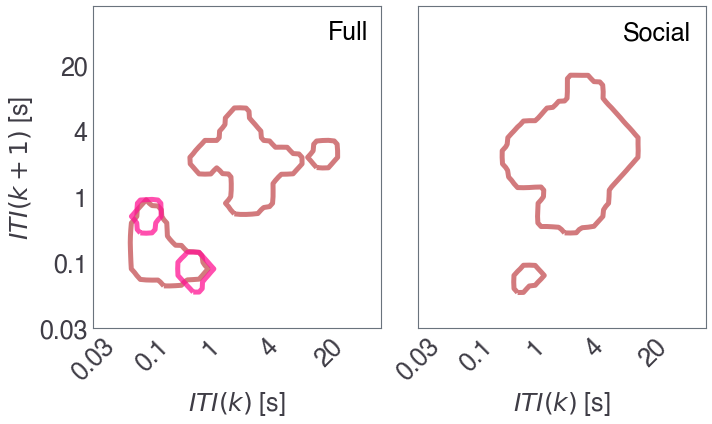

In [29]:
VALUES = [res_cRT, res_global]
CMAPS = ['r', 'deeppink']
TITLES = ['Reaction time (choice)', 'Task switch (global cost)'] 
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, _title in enumerate(['Full', 'Social']):
    for IDX in range(2):
        data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
        mask = data_it[7].reshape(50, 50).T
        p_vals = data_it[8].reshape(50, 50).T
        f_vals = data_it[9].reshape(50, 50).T
        r_vals = data_it[10].reshape(50, 50).T
        r2_vals = data_it[11].reshape(50, 50).T
        k = data_it[12][:, 0].reshape(50, 50).T
        f_vals[f_vals < 0] = 0
        Z = f_vals
        norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
        im = ax[i].contour(Z * np.sign(mask), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)
        if IDX == 0:
            ax[i].text(x_bias[i], 44, f"{jid_title[i]}", fontsize=25, color='black')
        ax[i].plot([0], [0], color=CMAPS[IDX], label=TITLES[IDX], linewidth=5)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlabel(r'$ITI(k)$ [s]')
        ax[i].grid(False)
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]')
plt.tight_layout()
# ax[1].legend(loc='upper center', shadow=True, fancybox=True, ncol=1, bbox_to_anchor=[0, 0.5])
plt.savefig('figure_5_panel_c_no_legend.pdf', transparent=True)

# Supplementary b.i.

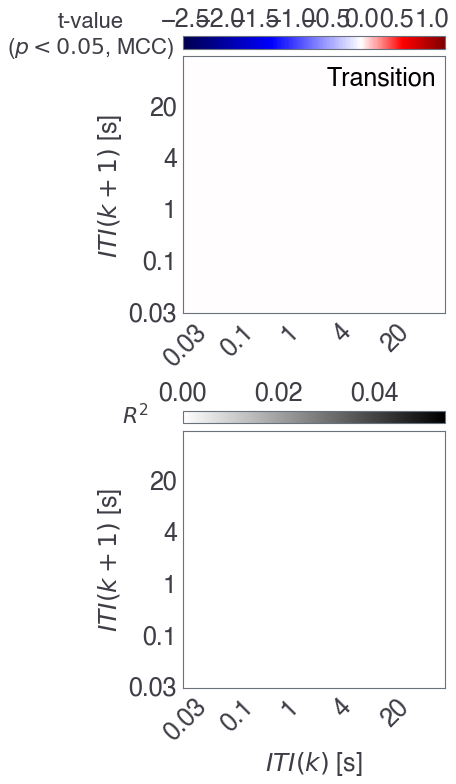

In [40]:
TITLES = ['cRT', 'switchGlobal'] 
VALUES = [res_cRT, res_global]
fig, ax = plt.subplots(2, 1, figsize=(7, 11), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 1 # 0 == cRT // 1 == switchGlobal

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(1):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][3].flat[0][2].flat[0]
    mask = data_it[7].reshape(50, 50).T
    p_vals = data_it[8].reshape(50, 50).T
    f_vals = data_it[9].reshape(50, 50).T
    r_vals = data_it[10].reshape(50, 50).T
    r2_vals = data_it[11].reshape(50, 50).T
    k = data_it[12][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_vals, 99))
    vmin_r = min(vmin_r, np.percentile(r2_vals, 1))

th_R2 = 0.1

for i, _title in enumerate(['Transition']):

    # val for age
    val = VALUES[IDX][3].flat[0][1].flat[0]
    mdl = val[2]
    r2_full = np.zeros(2500)
    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
    mask_age_r2 = r2_full.reshape(50, 50).T > th_R2
    
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[7].reshape(50, 50).T
    p_vals = data_it[8].reshape(50, 50).T
    f_vals = data_it[9].reshape(50, 50).T
    r_vals = data_it[10].reshape(50, 50).T
    r2_vals = data_it[11].reshape(50, 50).T
    k = data_it[12][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    im = ax[0].imshow(mask_age_r2 * np.sign(mask) * np.sqrt(f_vals) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=vmin_f, vmax=vmax_f))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')
    ax[0].text(x_bias[2], 44, f"{jid_title[2]}", fontsize=25, color='black')
    ax[0].invert_yaxis()
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels)
    ax[0].xaxis.set_tick_params(rotation=45)
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0].grid(False)
    divider = make_axes_locatable(ax[0])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
#     r2_vals[r2_vals < 1e-5] = 0
    
    im = ax[1].imshow(mask_age_r2 * np.sign(mask) * r2_vals, aspect='auto', cmap='binary',
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none', norm=TwoSlopeNorm(0, vmin=-0.01, vmax=vmax_r))
    
    ax[1].invert_yaxis()
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)
    ax[1].xaxis.set_tick_params(rotation=45)
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    ax[1].set_xlabel(f'$ITI(k)$ [s]')
    ax[1].grid(False)
    divider = make_axes_locatable(ax[1])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-18, 50, 't-value\n' + r'($p<0.05$, MCC)', size=22, ha='center')   
ax[1].text(-12, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig(f'figure_5_supplementary_b_i_{TITLES[IDX]}.pdf', transparent=True)

# Supplementary b.ii.

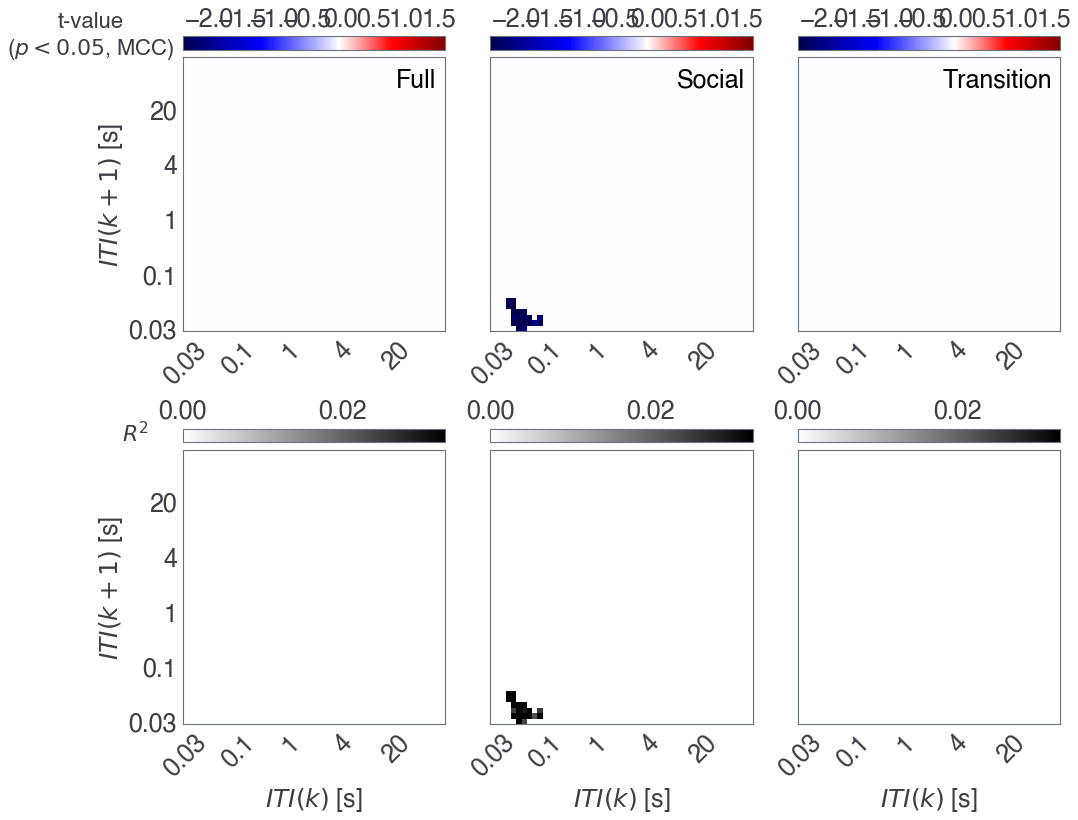

In [43]:
TITLES = ['sRT', 'Corsi'] 
VALUES = [res_sRT, res_corsi]
fig, ax = plt.subplots(2, 3, figsize=(15, 11.5), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0 # 0 == cRT // 1 == switchGlobal

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(3):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[7].reshape(50, 50).T
    p_vals = data_it[8].reshape(50, 50).T
    f_vals = data_it[9].reshape(50, 50).T
    r_vals = data_it[10].reshape(50, 50).T
    r2_vals = data_it[11].reshape(50, 50).T
    k = data_it[12][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_vals, 99))
    vmin_r = min(vmin_r, np.percentile(r2_vals, 1))

th_R2 = 0.1

for i, _title in enumerate(['Full', 'Social', 'Transition']):

    # val for age
    val = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    mdl = val[2]
    r2_full = np.zeros(2500)
    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
    mask_age_r2 = r2_full.reshape(50, 50).T > th_R2
    
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[7].reshape(50, 50).T
    p_vals = data_it[8].reshape(50, 50).T
    f_vals = data_it[9].reshape(50, 50).T
    r_vals = data_it[10].reshape(50, 50).T
    r2_vals = data_it[11].reshape(50, 50).T
    k = data_it[12][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    im = ax[0][i].imshow(mask_age_r2 * np.sign(mask) * np.sqrt(f_vals) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=vmin_f, vmax=vmax_f))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')
    ax[0][i].text(x_bias[i], 44, f"{jid_title[i]}", fontsize=25, color='black')
    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
#     r2_vals[r2_vals < 1e-5] = 0
    
    im = ax[1][i].imshow(mask_age_r2 * np.sign(mask) * r2_vals, aspect='auto', cmap='binary',
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none', norm=TwoSlopeNorm(0, vmin=-0.01, vmax=vmax_r))
    
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(f'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-18, 50, 't-value\n' + r'($p<0.05$, MCC)', size=22, ha='center')      
ax[1][0].text(-12, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig(f'figure_5_supplementary_b_ii_{TITLES[IDX]}.pdf', transparent=True)

# Extra single subsets age R2

In [6]:
TITLES = ['sRT', 'cRT', 'switchGlobal', 'switchLocal', 'Corsi', '2back'] 
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0 # 0 == cRT // 1 == switchGlobal
df_extra = pd.DataFrame(columns={'test', 'JID', 'N', 'max(R2)', 'F-value(max(R2))', 'beta(max(R2))'})

for IDX in range(6):
    for i, _title in enumerate(['Full', 'Social', 'Transition']):

        age = VALUES[IDX][0].flat[0][3]
        residual = VALUES[IDX][ORDER[i]].flat[0][2].flat[0] # residual
        mdl = residual[2]
        r2_full = np.zeros(2500)
        f_vals = np.zeros(2500)
        p_vals = np.zeros(2500)
        beta_vals = np.zeros((2500, 2))
        # mdl is 2500 long
        for j, obj in enumerate(mdl):
            pixel = obj.flat[0][0][0]
            r2_full[j] = pixel[0][0][0]
            f_vals[j] = pixel[1][0][0]
            p_vals[j] = pixel[2][0][0]
            beta_vals[j] = pixel[3].squeeze()
            
        betas = beta_vals[:, 0]
        r2_full = r2_full * (p_vals < 0.05)
        r2_full[np.isnan(r2_full)] = 0.
        idx = np.argmax(r2_full) 
        df_extra = df_extra.append({'test': TITLES[IDX], 'JID': _title, 'N': len(age), 'F-value(max(R2))': f_vals[idx], 
                                    'beta(max(R2))': betas[idx],
                                          'max(R2)': r2_full[idx]}, ignore_index=True)
        print(f"Max R2 {_title} = {np.max(r2_full):.2f}")

df_extra.to_csv(f'figure_5_extra_subsets.csv', index=False)
df_extra

Max R2 Full = 0.56
Max R2 Social = 0.34
Max R2 Transition = 0.59
Max R2 Full = 0.56
Max R2 Social = 0.34
Max R2 Transition = 0.59
Max R2 Full = 0.61
Max R2 Social = 0.35
Max R2 Transition = 0.65
Max R2 Full = 0.61
Max R2 Social = 0.35
Max R2 Transition = 0.65
Max R2 Full = 0.57
Max R2 Social = 0.33
Max R2 Transition = 0.56


<ipython-input-6-ad3a58017c5c>:29: RuntimeWarning: invalid value encountered in multiply
  r2_full = r2_full * (p_vals < 0.05)


Max R2 Full = 0.58
Max R2 Social = 0.46
Max R2 Transition = 0.62


,JID,beta(max(R2)),F-value(max(R2)),N,max(R2),test
0,Full,-0.050315,227.076520,179,0.563644,sRT
1,Social,-0.020659,87.110371,179,0.338091,sRT
2,Transition,0.009884,243.763411,179,0.590690,sRT
3,Full,-0.050542,228.934802,180,0.564334,cRT
4,Social,-0.020732,88.309126,180,0.339912,cRT
5,Transition,0.009871,244.459414,180,0.589837,cRT
6,Full,-0.053015,173.816064,117,0.613343,switchGlobal
7,Social,-0.162415,53.541397,117,0.345170,switchGlobal
8,Transition,0.010988,209.922285,117,0.650432,switchGlobal
9,Full,-0.053015,173.816064,117,0.613343,switchLocal
